In [1]:
from __future__ import print_function, division
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns
from operator import itemgetter
from skimage import io, transform
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils, models
from torchmetrics import F1Score
from torchvision import transforms, utils, models
from torchsummary import summary

import torchbearer
from torchbearer import Trial, metrics, Metric
from torchbearer.callbacks import Best, ModelCheckpoint

import optuna
from optuna.samplers import TPESampler, RandomSampler

import ipywidgets
from tqdm import tqdm
import segmentation_models_pytorch as smp
import cv2

from PIL import Image

import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
class AdjacencyDataset(Dataset):
    """Apples Dataset"""

    def __init__(self, folders, lab=[0], test=False):
        """
        Args:
        """
        
        self.test=test
        self.data = np.vstack([np.loadtxt(f) for f in folders])
        self.lenghts = [len(np.loadtxt(f)) for f in folders]
        if not test:
            self.labels = np.concatenate([np.ones(self.lenghts[i])*l for i,l in enumerate(lab)])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.test:
            return torch.from_numpy(self.data[idx]).type(torch.FloatTensor)
        else:
            return [torch.from_numpy(self.data[idx]).type(torch.FloatTensor), int(self.labels[idx])]
        

In [3]:
mydat = AdjacencyDataset(folders=["Files/MachineLearning/nonco.txt",
                                  "Files/MachineLearning/n1o.txt",
                                  "Files/MachineLearning/n2o.txt",
                                  "Files/MachineLearning/n3o.txt",
                                  "Files/MachineLearning/random.txt",
                                  "Files/MachineLearning/n5o.txt",
                                  "Files/MachineLearning/n6o.txt", 
                                  "Files/MachineLearning/o1n.txt"],
                         lab=[0,1,2,3,4,5,6,7],
                         test=False)

train_dim=int(len(mydat)*0.9)
val_dim=int(len(mydat)-train_dim)

mydat_train, mydat_val = random_split(mydat, [train_dim, val_dim])

train_dataloader = DataLoader(mydat_train, batch_size=10, shuffle=True, num_workers=0)
val_dataloader = DataLoader(mydat_val, batch_size=20, shuffle=False, num_workers=0)

In [4]:
mydat_test = AdjacencyDataset(folders=["Files/MachineLearning/n1s.txt", 
                                       "Files/MachineLearning/n1o1s.txt",
                                       "Files/MachineLearning/n2o1s.txt",
                                       "Files/MachineLearning/n3o1s.txt",
                                       "Files/MachineLearning/n4o1s.txt",
                                       ],
                              test=True)

test_dataloader = DataLoader(mydat_test, batch_size=10, shuffle=False, num_workers=0)

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(in_features=15479, out_features=200)
        self.lin2 = nn.Linear(in_features=200, out_features=50)
        self.lin3 = nn.Linear(in_features=50, out_features=8)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

model = Model()
model=model.cpu()


In [10]:
check_best = Best('checkpoints/check_best.pth', monitor='val_acc', mode='max')
check_last = ModelCheckpoint('checkpoints/check_last.pth')

trial = Trial(model,
                 optim.Adam(model.parameters(), lr=5e-04), 
                 nn.CrossEntropyLoss(), 
                 metrics=["loss", "acc"],
                 callbacks=[check_best, check_last])

trial.load_state_dict(torch.load("checkpoints/check_best_0class.pth"))
print("net loaded")

net loaded


In [12]:
trial.with_generators(train_generator=train_dataloader, 
                          val_generator=val_dataloader, 
                          test_generator=test_dataloader)

#mytrial = trial.run()
mytrial = trial.run(epochs=74, verbose=1)

100%|##########| 74/74 [00:00<?, ?it/s]

100%|##########| 74/74 [00:00<?, ?it/s]

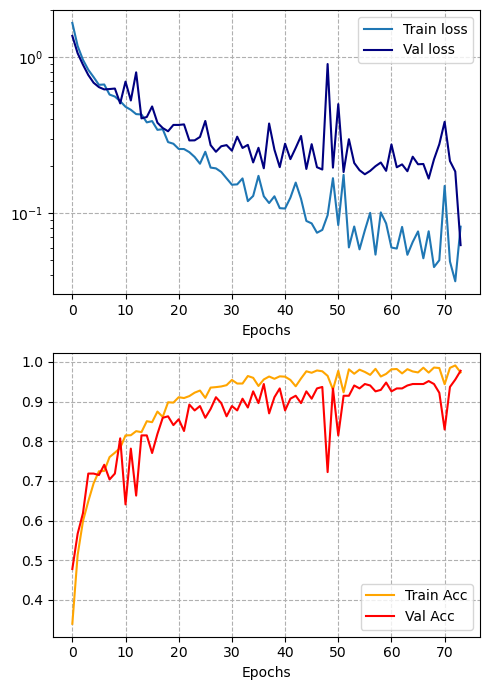

In [13]:
__, ax = plt.subplots(2,1,figsize=(5,7))

ax[0].semilogy([mt["loss"] for mt in mytrial], label="Train loss", color="C0")
ax[0].semilogy([mt["val_loss"] for mt in mytrial], label="Val loss", color="navy")

ax[1].plot([mt["acc"] for mt in mytrial], label="Train Acc", color="orange")
ax[1].plot([mt["val_acc"] for mt in mytrial], label="Val Acc", color="red")

[axi.set_xlabel("Epochs") for axi in ax]
[axi.legend() for axi in ax]
[axi.grid(ls="--") for axi in ax]

plt.tight_layout()

In [14]:
predicted_lab=np.argmax(trial.predict(),axis=1).detach().numpy()

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

In [15]:
trial.predict().detach().numpy()

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

array([[  66.991005 ,   46.91552  ,   26.327566 , ..., -169.11978  ,
        -277.31015  , -367.08456  ],
       [  49.402164 ,   37.060898 ,   20.60561  , ..., -131.32974  ,
        -218.08606  , -289.8701   ],
       [  61.920643 ,   44.7238   ,   25.145082 , ..., -159.4754   ,
        -263.22495  , -350.14676  ],
       ...,
       [ -24.258877 ,   -7.609163 ,    3.1533566, ...,  -47.69067  ,
         -87.54909  , -122.31704  ],
       [ -36.421207 ,  -23.542395 ,   -6.142934 , ...,  -33.027756 ,
         -65.4409   , -100.6639   ],
       [ -30.641468 ,  -12.099226 ,    1.0636925, ...,  -44.891083 ,
         -84.51767  , -122.97745  ]], dtype=float32)

In [36]:
print("Nonco+Sars: \t\t%.2f±%.2f" %(np.mean(predicted_lab[0:100]), np.std(predicted_lab[0:100])))
print("Nonco+Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[100:200]), np.std(predicted_lab[100:200])))
print("Nonco+2Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[200:300]), np.std(predicted_lab[200:300])))
print("Nonco+3Onco+Sars: \t%.2f±%.2f" %(np.mean(predicted_lab[300:400]), np.std(predicted_lab[300:400])))

Nonco+Sars: 		0.02±0.14
Nonco+Onco+Sars: 	0.65±0.48
Nonco+2Onco+Sars: 	1.10±0.30
Nonco+3Onco+Sars: 	1.72±0.49


In [15]:
val_dim

270

0/1(p):   0%|          | 0/14 [00:00<?, ?it/s]

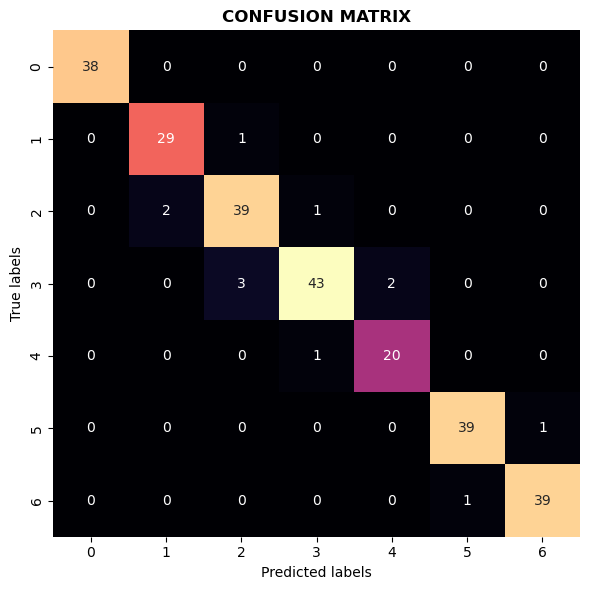

In [34]:
val_pred=np.argmax(trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy(),axis=1)
val_true=[v[1] for v in val_dataloader.dataset]

confM_val = confusion_matrix(y_true = val_true, y_pred = val_pred, labels=np.arange(7))

plt.figure(figsize=(6,6))
sns.heatmap(confM_val, annot=True, fmt="g", cbar=False, cmap="magma")
plt.title("CONFUSION MATRIX", weight="bold")
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
plt.tight_layout()

In [ ]:
folders=["Files/MachineLearning/nonco.txt",
                                  "Files/MachineLearning/n1o.txt",
                                  "Files/MachineLearning/n2o.txt",
                                  "Files/MachineLearning/n3o.txt",
                                  "Files/MachineLearning/random.txt",
                                  "Files/MachineLearning/n5o.txt",
                                  "Files/MachineLearning/n6o.txt", 
                                  "Files/MachineLearning/o1n.txt"]
trainn = np.vstack([np.loadtxt(f) for f in folders])
lenghts = [len(np.loadtxt(f)) for f in folders]
labels = np.concatenate([np.ones(lenghts[i])*l for i,l in enumerate([0,1,2,3,4,5,6,7])])

In [25]:
reddim_val = trial.predict(data_key=torchbearer.VALIDATION_DATA).detach().numpy()
reddim_test = trial.predict().detach().numpy()
val_true=[v[1] for v in val_dataloader.dataset]

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/14 [00:00<?, ?it/s]

74it [00:00, ?it/s]

0/1(p):   0%|          | 0/50 [00:00<?, ?it/s]

In [33]:
reddim_pred.shape

(270, 8)

In [32]:
np.vstack([reddim_pred, reddim_test]).shape

(770, 8)

In [51]:
sklearn.externals.joblib

AttributeError: module 'sklearn.externals' has no attribute 'joblib'

In [55]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA on the data
pca = PCA(n_components=2)
pca.fit(reddim_pred)

# Transform new data using the fitted PCA
pca_val = pca.transform(reddim_val)
pca_test = pca.transform(reddim_pred)

In [54]:
from sklearn.manifold import TSNE

import joblib
# Fit the TSNE model on the training data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(np.vstack([reddim_pred, reddim_test]))

# Save the TSNE model using joblib
joblib.dump(tsne, 'tsne_model.pkl')

# Load the TSNE model from file
tsne = joblib.load('tsne_model.pkl')

# Transform new samples using the loaded TSNE model
X_tsne_new = tsne.transform(reddim_test)

AttributeError: 'TSNE' object has no attribute 'transform'

<Axes: >

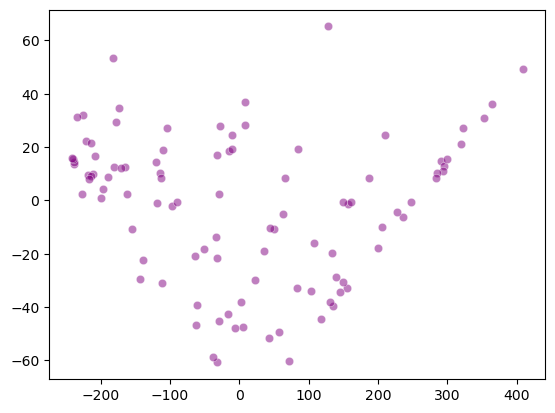

In [73]:
from sklearn import manifold

transf = manifold.TSNE(2, perplexity=15, early_exaggeration=7)
trasformatoo = transf.fit_transform(np.vstack([reddim_pred, reddim_test]))
#teat_transf = transf.fit_transform(reddim_test)
#sns.scatterplot(pca_val[:,0], pca_val[:,1], hue=val_true, palette="Set1")
sns.scatterplot(pca_test[:100,0], pca_test[:100,1], alpha=0.5, color="purple")


In [44]:
import umap

umap = umap.UMAP(2)
transkkk=umap.fit_transform(np.vstack([reddim_pred, reddim_test]))

<Axes: >

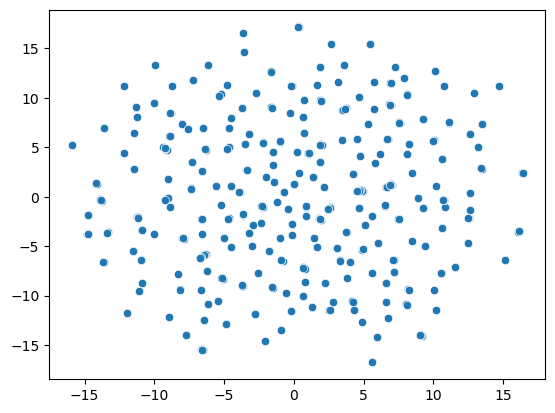

In [45]:
sns.scatterplot(transkkk[:,0], transkkk[:,1])#, hue=labels, palette="Set1")

# Random Forest

In [74]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import optuna
from optuna.samplers import TPESampler, RandomSampler

In [2]:
virus_metadata = pd.read_csv("../Data/Files/viruses_metadata.csv", header=0, sep=";")

virus_metadata_onco = virus_metadata[virus_metadata["isOncogenic"] == True].reset_index()
virus_metadata_nonco = virus_metadata[virus_metadata["isOncogenic"] == False].reset_index()

#dictionary containing a unquie mapping between name of the protein and a corresponding index
node_map_df = pd.read_csv("../Data/Files/node_map.csv")
node_map_dict = {k:(v-1) for k,v in zip(node_map_df["Prot"], node_map_df["Index"])}

In [44]:
importance_scores_list = []
predicted_class_list = []
acc_list = []

def random_tree_MINE(X_train, y_train, X_val, y_val, X_test, max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features, criterion, what_return="score"):
    num_features = X.shape[1]


    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators,
                                           max_depth=max_depth, 
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           max_features=max_features,
                                           criterion=criterion)

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y_train)

    y_val_pred = rf_classifier.predict(X_val)
    if what_return=="score":
        return np.mean(np.abs(y_val-y_val_pred))
    else:
        # Calculate the accuracy of the model on the training data
        accuracy = accuracy_score(y_val, y_val_pred)
        acc_list.append(accuracy)
        # Classify the new sample
        predicted_class = rf_classifier.predict(X_pred)
        predicted_class_list.append(predicted_class)

        # Classify the new sample
        predicted_class = rf_classifier.predict(X_pred)
        predicted_class_list.append(predicted_class)

        #print("Mean predicted class:", np.mean(predicted_class))

        importance_scores = rf_classifier.feature_importances_
        importance_scores_list.append(importance_scores)

        # Sort the features by importance in descending order
        sorted_indices = np.argsort(importance_scores)[::-1]

        return y_val_pred

    # Print the top 10 most important features
    top_features = 3
    #print("Top", top_features, "features:")
    #for i in range(top_features):
    #    feature_index = sorted_indices[i]
    #    print("Feature", node_map_df.loc[feature_index]["Prot"], "- Importance:", importance_scores[feature_index])

## Topology

In [3]:
top_dir = os.listdir("../Data/topology")
top_dir_train = top_dir[:-2]
top_dir_pred = top_dir[-2:-1]
top_dir_pred

['n1s']

In [55]:
#training samples
X = []
for t in top_dir_train:
    for i in os.listdir("../Data/topology/"+t):
        X.append(np.loadtxt("../Data/topology/"+t+"/"+i))
X=np.array(X)

#training samples labels
label_dict = dict(zip(top_dir_train, [4,7,6,3,5,1,2,0]))

y = []
for t in top_dir_train:
    y.append([label_dict[t]]*len(os.listdir("../Data/topology/"+t)))

y = np.concatenate(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(X_val.shape)

# samples with sarscov2
X_pred = []
for t in top_dir_pred:
    for i in os.listdir("../Data/topology/"+t):
        X_pred.append(np.loadtxt("../Data/topology/"+t+"/"+i))

X_pred = np.array(X_pred)

(1306, 15479)
(146, 15479)


In [56]:
y_val_pred = random_tree_MINE(X_train=X_train, 
                            y_train=y_train, 
                            X_val=X_val, 
                            y_val=y_val, 
                            X_test=X_pred,
                            n_estimators=100,
                            max_depth=48, 
                            min_samples_split=8, 
                            min_samples_leaf=6,
                            max_features="sqrt",
                            criterion="entropy",
                            what_return="all")

In [42]:
def objective(trial):

    # set the range of the transformations to apply to the image
    hyperparameters = [
        #trial.suggest_int("n_estimators", 50,150),
        trial.suggest_int("max_depth", 1, 100),
        trial.suggest_int("min_samples_split", 2,10),
        trial.suggest_int("min_samples_leaf", 1,10),
        trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"])
    ]
    
    return random_tree_MINE(X_train=X_train, 
                            y_train=y_train, 
                            X_val=X_val, 
                            y_val=y_val, 
                            X_test=X_pred, 
                            n_estimators = 100,
                            max_depth=hyperparameters[0], 
                            min_samples_split=hyperparameters[1], 
                            min_samples_leaf=hyperparameters[2],
                            max_features=hyperparameters[3],
                            criterion = hyperparameters[4])

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
sampler = TPESampler(seed=12345)
study = optuna.create_study(study_name="random tree", direction="minimize", pruner=pruner, sampler=sampler)
optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(objective, n_trials=50)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("   Max IoU: {}".format(trial.value))

print("   Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-05-19 17:15:43,681] A new study created in memory with name: random tree
[I 2023-05-19 17:15:44,888] Trial 0 finished with value: 0.8356164383561644 and parameters: {'max_depth': 93, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.8356164383561644.
[I 2023-05-19 17:15:51,830] Trial 1 finished with value: 0.6643835616438356 and parameters: {'max_depth': 75, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'criterion': 'log_loss'}. Best is trial 1 with value: 0.6643835616438356.
[I 2023-05-19 17:15:55,837] Trial 2 finished with value: 0.7534246575342466 and parameters: {'max_depth': 81, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.6643835616438356.
[I 2023-05-19 17:15:56,716] Trial 3 finished with value: 0.7671232876712328 and parameters: {'max_depth': 44, 'min_samples_split': 8, 'min_samples_leaf': 10, 

KeyboardInterrupt: 

<Axes: >

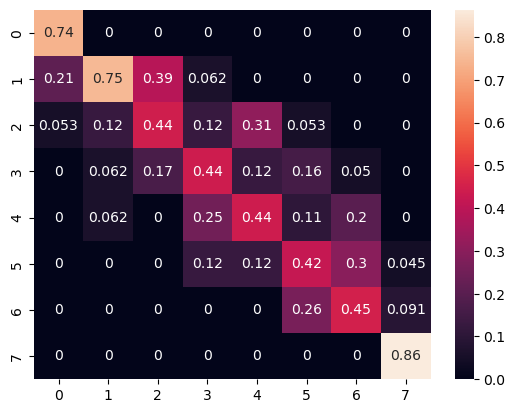

In [79]:
sns.heatmap(confusion_matrix(y_pred=y_val_pred, y_true=y_val, normalize="pred"), annot=True)

array([-2, -2,  0,  0,  0,  2, -1,  0,  1,  0, -2, -1,  0,  0,  0, -1, -1,
        2,  0,  0,  0,  1,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  1,  0,
       -2,  0,  0,  0, -1,  0,  0, -2,  0,  3, -2,  0, -2,  0,  0,  0,  0,
       -2,  0,  0,  1,  0, -1,  0, -2,  0,  0,  1,  0,  0,  0,  1,  0,  0,
        0, -3,  0, -2,  0,  0,  0,  2, -1,  1,  1,  0, -1,  0,  1, -1,  0,
        0,  1,  0,  0,  0,  1,  0,  0, -2, -1,  0,  0,  1, -1,  0,  0, -1,
        0, -1,  0, -1, -2,  2,  0,  0, -2, -3, -1,  1,  0,  0,  0,  0,  0,
        1,  0, -1,  0,  1,  1,  0,  0,  0,  0,  1, -1,  0,  0, -1,  1,  0,
        0, -1,  0,  0,  0,  1,  0, -1,  0, -2])

In [72]:
d_pred = y_val-y_val_pred
print(np.mean(abs(d_pred)))
print(np.mean(d_pred[d_pred>0]))
print(np.mean(d_pred[d_pred<0]))

0.589041095890411
1.24
-1.4864864864864864


In [33]:
len(y_train)

863

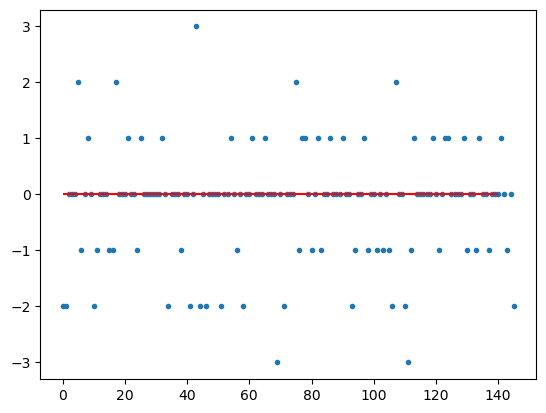

In [57]:
plt.plot((y_val-y_val_pred), ".")
plt.hlines(0,0,140, color="r")

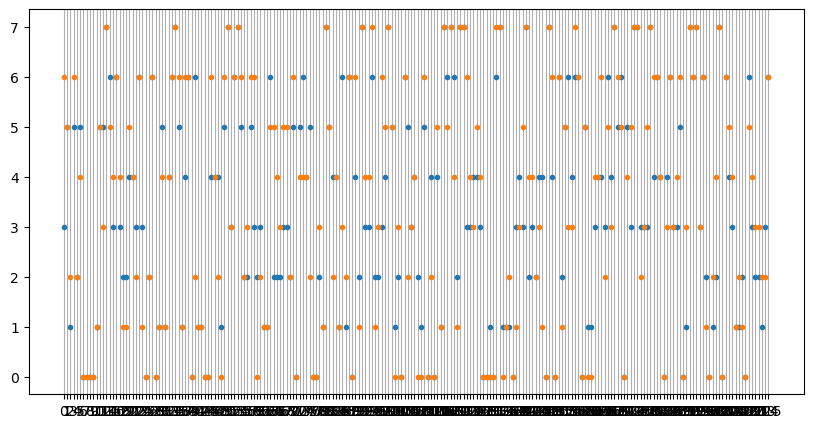

In [31]:
plt.figure(figsize=(10,5))
plt.plot(y_val,".")
plt.plot(y_val_pred,".")
plt.xticks(np.arange(len(y_val)))
plt.grid(axis="x")

In [127]:
for v, vp in zip(y_val, y_val_pred):
    print(v,vp,abs(v-vp))

3 6 3
5 5 0
1 2 1
5 6 1
2 2 0
5 5 0
0 0 0
0 0 0
0 0 0
0 0 0
1 1 0
5 5 0
5 3 2
7 7 0
6 5 1
3 4 1
6 6 0
3 4 1
2 0 2
2 1 1
4 4 0
4 4 0
3 2 1
6 6 0
3 1 2
0 0 0
2 2 0
6 6 0
0 1 1
1 1 0
5 6 1
1 1 0
4 4 0
6 6 0
7 7 0
5 7 2
1 1 0
4 6 2
6 6 0
0 0 0
6 3 3
1 0 1
1 2 1
0 0 0
0 0 0
4 6 2
4 4 0
4 3 1
1 0 1
5 6 1
7 7 0
3 3 0
6 6 0
7 7 0
5 6 1
2 2 0
2 3 1
5 6 1
3 6 3
2 0 2
3 4 1
1 1 0
1 1 0
6 3 3
2 5 3
2 3 1
2 3 1
3 2 1
3 2 1
2 3 1
5 6 1
0 0 0
5 5 0
6 5 1
4 3 1
5 2 3
0 0 0
0 0 0
2 2 0
1 1 0
7 7 0
5 5 0
4 2 2
4 7 3
1 1 0
6 3 3
1 2 1
6 6 0
0 0 0
4 6 2
2 1 1
7 7 0
3 4 1
3 4 1
6 7 1
2 1 1
2 3 1
3 4 1
4 4 0
7 7 0
5 5 0
1 0 1
2 1 1
0 0 0
6 6 0
5 2 3
3 3 0
4 3 1
2 0 2
1 0 1
5 6 1
0 0 0
4 3 1
0 0 0
4 5 1
1 1 0
7 7 0
6 5 1
7 7 0
6 4 2
2 2 0
7 7 0
7 7 0
3 2 1
3 4 1
4 5 1
4 5 1
3 3 0
0 0 0
0 0 0
1 0 1
0 0 0
6 7 1
7 7 0
1 0 1
1 1 0
1 1 0
0 0 0
3 2 1
4 5 1
3 5 2
7 7 0
2 3 1
3 5 2
2 2 0
4 3 1
4 1 3
0 0 0
7 7 0
4 6 2
0 0 0
6 6 0
2 1 1
5 5 0
6 3 3
4 3 1
6 7 1
6 6 0
0 0 0
5 5 0
1 0 1
1 0 1
3 4 1
4 1 3
4 6 2
3 2 1
6 5 

In [126]:
y_val

array([3, 5, 1, 5, 2, 5, 0, 0, 0, 0, 1, 5, 5, 7, 6, 3, 6, 3, 2, 2, 4, 4,
       3, 6, 3, 0, 2, 6, 0, 1, 5, 1, 4, 6, 7, 5, 1, 4, 6, 0, 6, 1, 1, 0,
       0, 4, 4, 4, 1, 5, 7, 3, 6, 7, 5, 2, 2, 5, 3, 2, 3, 1, 1, 6, 2, 2,
       2, 3, 3, 2, 5, 0, 5, 6, 4, 5, 0, 0, 2, 1, 7, 5, 4, 4, 1, 6, 1, 6,
       0, 4, 2, 7, 3, 3, 6, 2, 2, 3, 4, 7, 5, 1, 2, 0, 6, 5, 3, 4, 2, 1,
       5, 0, 4, 0, 4, 1, 7, 6, 7, 6, 2, 7, 7, 3, 3, 4, 4, 3, 0, 0, 1, 0,
       6, 7, 1, 1, 1, 0, 3, 4, 3, 7, 2, 3, 2, 4, 4, 0, 7, 4, 0, 6, 2, 5,
       6, 4, 6, 6, 0, 5, 1, 1, 3, 4, 4, 3, 6, 4, 7, 5, 6, 0, 5, 3, 7, 7,
       3, 3, 3, 7, 4, 6, 4, 0, 4, 6, 3, 3, 5, 0, 1, 7, 6, 7, 3, 6, 2, 0,
       1, 2, 7, 0, 6, 4, 3, 1, 1, 2, 0, 6, 3, 2, 2, 1, 3, 6])

In [42]:
print("Predicted labels statistics: %.4f ± %.4f" %(np.mean(predicted_class_list), np.std(predicted_class_list)))

Predicted labels statistics: 1.0050 ± 0.3777


In [37]:
sorted_indices = np.argsort(np.mean(importance_scores_list, axis=0))[::-1]
node_map_df.loc[sorted_indices]

,Index,Prot
9317,9318,CDH6
2194,2195,ATRX
9010,9011,APC2
9318,9319,CDH9
8946,8947,FAM171B
...,...,...
14291,14292,TRPT1
14290,14291,UGT2A2
14289,14290,NUDT16
14288,14289,PDXP


In [38]:
res_df = pd.DataFrame({"Prot": node_map_df.loc[sorted_indices]["Prot"], "Score": np.sort(importance_scores)[::-1]})
res_df[res_df["Score"]>1e-3]

,Prot,Score
9317,CDH6,0.002634
2194,ATRX,0.002410
9010,APC2,0.002408
9318,CDH9,0.002311
8946,FAM171B,0.002292
...,...,...
7950,SCEL,0.001016
8658,SBSN,0.001010
8767,EPS8L1,0.001008
1206,HIST2H3PS2,0.001004


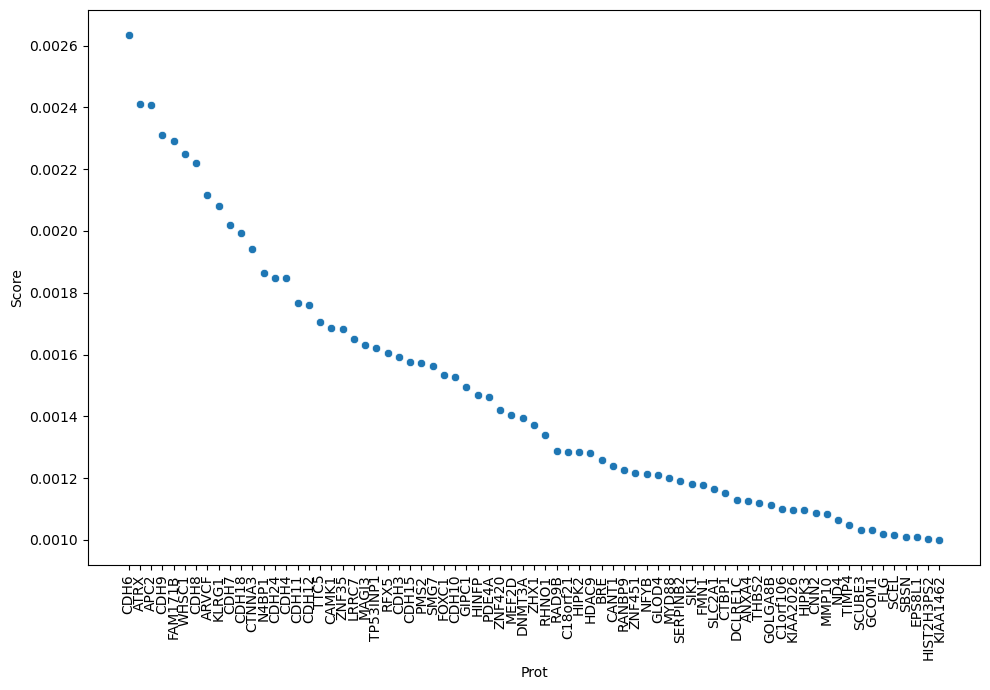

In [39]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=res_df[res_df["Score"]>1e-3], x="Prot", y="Score")
plt.xticks(rotation=90)
plt.tight_layout()

## Enrichment

In [48]:
enr_dir = os.listdir("../Data/pathways/")
enr_dir_train = enr_dir[:-2]
print(enr_dir_train)
enr_dir_pred = enr_dir[-2:-1]
enr_dir_pred

['n4o', 'o1n', 'n6o', 'n3o', 'n5o', 'n1o', 'n2o', 'n']


['n1s']

In [110]:
path_list = []
for t in enr_dir:
    for i in os.listdir("../Data/pathways/"+t):
        path_list= np.concatenate([path_list, pd.read_csv("../Data/pathways/"+t+"/"+i)["Term"].to_numpy()])
        path_list = np.unique(path_list)

path_dict = dict(zip(path_list, np.arange(len(path_list))))

#training samples
X = []
for t in enr_dir_train:
    for i in os.listdir("../Data/pathways/"+t):
        ex_df = pd.read_csv("../Data/pathways/"+t+"/"+i)
        path_arr = np.zeros(len(path_list))
        path_arr[np.array(itemgetter(*ex_df["Term"])(path_dict))]= ex_df["Adjusted P-value"].map(lambda x: -np.log10(x))
        X.append(path_arr)
X=np.array(X)
print(X.shape)

#training samples labels
label_dict = dict(zip(top_dir_train, [4,7,6,3,5,1,2,0]))

y = []
for t in enr_dir_train:
    y.append([label_dict[t]]*len(os.listdir("../Data/pathways/"+t)))

y = np.concatenate(y)
print(y.shape)

# samples with sarscov2
X_pred = []
for t in enr_dir_pred:
    for i in os.listdir("../Data/pathways/"+t):
        ex_df = pd.read_csv("../Data/pathways/"+t+"/"+i)
        path_arr = np.zeros(len(path_list))
        path_arr[np.array(itemgetter(*ex_df["Term"])(path_dict))]= ex_df["Adjusted P-value"].map(lambda x: -np.log10(x))
        X_pred.append(path_arr)

X_pred = np.array(X_pred)
print(X_pred.shape)

(1089, 203)
(1089,)
(135, 203)


In [111]:
importance_scores_list = []
predicted_class_list = []
acc_list = []


def random_tree_MINE(X,y)
    num_features = X.shape[1]


    # Create a Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Fit the classifier to the input data
    rf_classifier.fit(X_train, y)

    y_pred = rf_classifier.predict(X_train)

    # Calculate the accuracy of the model on the training data
    accuracy = accuracy_score(y, y_pred)
    acc_list.append(accuracy)
    # Classify the new sample
    predicted_class = rf_classifier.predict(X_pred)
    predicted_class_list.append(predicted_class)

    #print("Mean predicted class:", np.mean(predicted_class))

    importance_scores = rf_classifier.feature_importances_
    importance_scores_list.append(importance_scores)

    # Sort the features by importance in descending order
    sorted_indices = np.argsort(importance_scores)[::-1]

    # Print the top 10 most important features
    top_features = 3
    #print("Top", top_features, "features:")
    #for i in range(top_features):
    #    feature_index = sorted_indices[i]
    #    print("Feature", node_map_df.loc[feature_index]["Prot"], "- Importance:", importance_scores[feature_index])

100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


In [112]:
acc_list

[0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681,
 0.9954086317722681]

In [118]:
rf_classifier

0.0

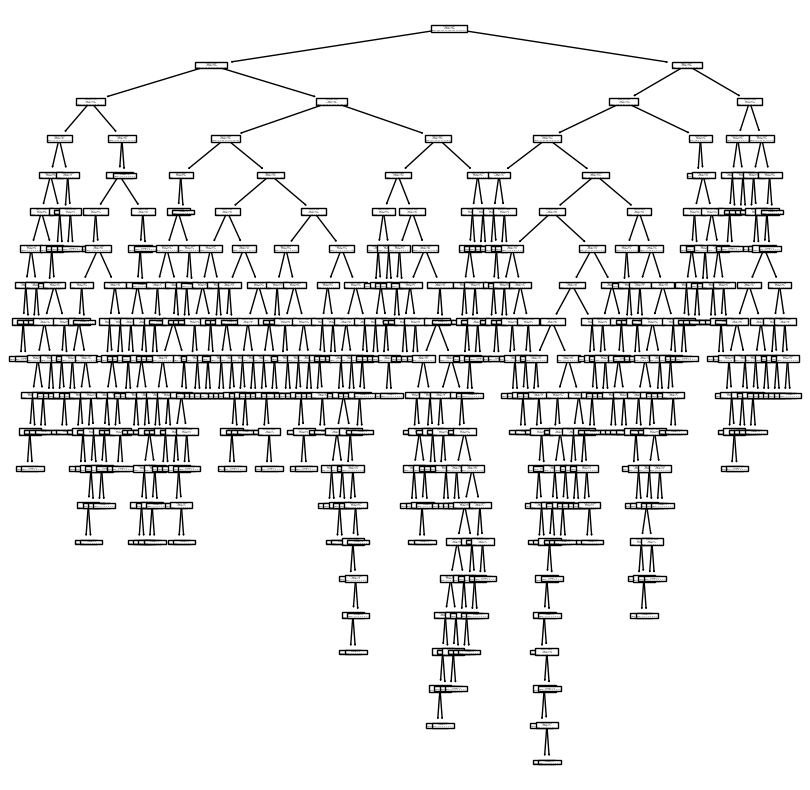

In [113]:
from sklearn import tree
# Extract the individual decision tree
decision_tree = rf_classifier.estimators_[0]

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the decision tree
tree.plot_tree(decision_tree, ax=ax)

# Show the plot
plt.show()